Before you turn this problem in, make sure everything runs as expected. First, **restart the kernel** (in the menubar, select Kernel$\rightarrow$Restart) and then **run all cells** (in the menubar, select Cell$\rightarrow$Run All).

**IMPORTANT: DO NOT COPY OR SPLIT CELLS.** If you do, you'll mess the autograder. If need more cells to work or test things out, create a new cell. You may add as many new cells as you need.

Make sure you fill in any place that says `YOUR CODE HERE` or "YOUR ANSWER HERE", as well as your name and group below:

In [1]:
COURSE = "Unsupervised Learning 2021"
GROUP = "D8A"
NAME = "Tokiyomi" # Match your GitHub Classroom ID

---

In [2]:
# Standard imports
import numpy as np
from matplotlib import pyplot as plt
from utils import print_class_limits

# Assignment: Discretization

In this assignment, you'll be required to implement different discretization strategies, as reviewed in the lectures. You may check your work against the expected outcome in the lecture notes.

- Equal frequency (2 pt)
- Clustering using 1D k-means (4 pts)
- Kernel density estimation (4 pts)

As in the lectures, we begin with the creation of some synthetic data.

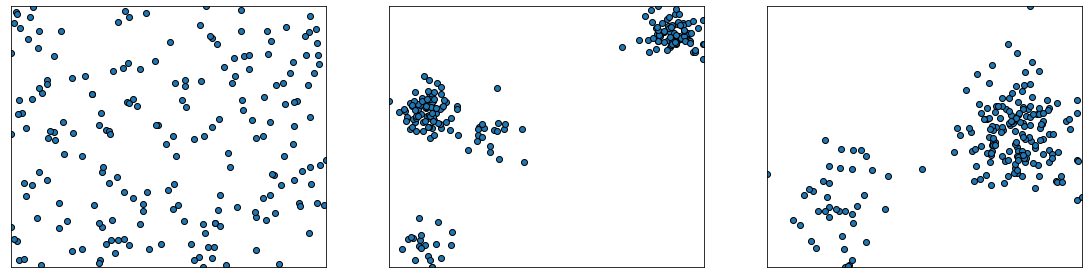

In [3]:
# taken from sklearn docs: https://scikit-learn.org/stable/auto_examples/preprocessing/plot_discretization_strategies.html#sphx-glr-auto-examples-preprocessing-plot-discretization-strategies-py

from sklearn.datasets import make_blobs

n_samples = 200
centers_0 = np.array([[0, 0], [0, 5], [2, 4], [8, 8]])
centers_1 = np.array([[0, 0], [3, 1]])

random_state = 42
X_list = [
    np.random.RandomState(random_state).uniform(-3, 3, size=(n_samples, 2)),
    make_blobs(n_samples=[n_samples // 10, n_samples * 4 // 10,
                          n_samples // 10, n_samples * 4 // 10],
               cluster_std=0.5, centers=centers_0,
               random_state=random_state)[0],
    make_blobs(n_samples=[n_samples // 5, n_samples * 4 // 5],
               cluster_std=0.5, centers=centers_1,
               random_state=random_state)[0],
]

figure = plt.figure(figsize=(6.4*3, 4.8))
for idx, X in enumerate(X_list):
    ax = plt.subplot(1, len(X_list), idx+1)
    ax.scatter(X[:, 0], X[:, 1], edgecolors='k')

    ax.set_xticks(())
    ax.set_yticks(())
    ax.set_xlim(np.min(X[:,0]), np.max(X[:,0]))
    ax.set_ylim(np.min(X[:,1]), np.max(X[:,1]))

## Equal frecuency (2 pt)

In [4]:
# Implement equal frecuency discretization below

def disc_eq_freq(X, k):
    # Implement equal frequency discretization with k bins.
    # Each feature should be discretized individually (univariate discretization).
    # Your code should work with a data matrix X with an arbitrary number of unsorted features.
    
    m, n = X.shape
    
    # Find class limits.
    # Hint: use -inf and +inf as the first and last limit

    clims = []
    quantiles = np.linspace(0, 100, k + 1) # compute k + 1 quantiles to have k intervals

    for i in range(n): # for each column
        
        clims.append((np.percentile(X[:,i], quantiles))) # compute the corresponding value of each quantile using percentile
    
    clims = np.array(clims)
    clims[:,0] = np.NINF
    clims[:,-1] = np.Inf
    
    X_disc = np.zeros(X.shape)

    for i in range(n): # compute the discretization for each column
        X_disc[:,i] = np.searchsorted(clims[i], X[:,i], side='right') - 1
        
    # Return the discretized labels in a matrix the same shape as X.
    # Return the limits in a matrix which rows are the interval classes of each feature.
    return X_disc, clims

To test the function employ the following test matrix:

In [5]:
X_test = np.array([[-2, 1, -4,   -1],
                   [-1, 2, -3, -0.5],
                   [ 0, 3, -2,  0.5],
                   [ 1, 4, -1,    2]])

X_disc, bin_edges = disc_eq_freq(X_test, 4)

print("The discretized matrix is:")
print(X_disc)
print("Expected answer:")
print("""[[0. 0. 0. 0.]
 [1. 1. 1. 1.]
 [2. 2. 2. 2.]
 [3. 3. 3. 3.]]""")
print()

print("The bin edges are:")
print(bin_edges)
print("Expected edges:")
print("""[[  -inf -1.25  -0.5    0.25     inf]
 [  -inf  1.75   2.5    3.25     inf]
 [  -inf -3.25  -2.5   -1.75     inf]
 [  -inf -0.625  0.     0.875    inf]]
""")


The discretized matrix is:
[[0. 0. 0. 0.]
 [1. 1. 1. 1.]
 [2. 2. 2. 2.]
 [3. 3. 3. 3.]]
Expected answer:
[[0. 0. 0. 0.]
 [1. 1. 1. 1.]
 [2. 2. 2. 2.]
 [3. 3. 3. 3.]]

The bin edges are:
[[  -inf -1.25  -0.5    0.25     inf]
 [  -inf  1.75   2.5    3.25     inf]
 [  -inf -3.25  -2.5   -1.75     inf]
 [  -inf -0.625  0.     0.875    inf]]
Expected edges:
[[  -inf -1.25  -0.5    0.25     inf]
 [  -inf  1.75   2.5    3.25     inf]
 [  -inf -3.25  -2.5   -1.75     inf]
 [  -inf -0.625  0.     0.875    inf]]



The following code plots the sample data sets and the equal frequency partition:

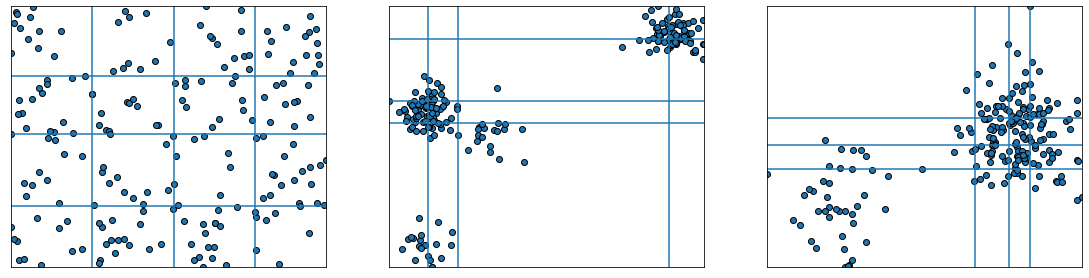

In [6]:
bin_edges = [disc_eq_freq(X, 4)[1][:,1:-1] for X in X_list]

figure = plt.figure(figsize=(6.4*3, 4.8))
for idx, X in enumerate(X_list):
    ax = plt.subplot(1, len(X_list), idx+1)
    ax.scatter(X[:, 0], X[:, 1], edgecolors='k')
    
    ax.set_xlim(np.min(X[:,0]), np.max(X[:,0]))
    ax.set_ylim(np.min(X[:,1]), np.max(X[:,1]))
    
    for x in bin_edges[idx][0]:
        ax.axvline(x)
    for y in bin_edges[idx][1]:
        ax.axhline(y)
    
    ax.set_xticks(())
    ax.set_yticks(())

## Discretization by clustering (4 pts)

Remember to follow the paper by Daniela Joita, attatched.

In [7]:
# Implement 1D k-means below

def k_means_1D(x, k):
    """ Implmentes K-means discretization.
    
    INPUT:
        x: one dimensional numpy array with the features to discretize
        k: number of bins
        
    OUTPUT:
        b: the bin edges
    """
    n = len(x)
    x = np.array(x)
    
    # We need an array for the cluster index of each point
    cluster = np.zeros(n, dtype=int)
    
    # Bin edges
    b = np.zeros(k + 1)
    
    # This variable monitors the reallocation of clusters.
    # change = true if at least one value is being moved to a different cluster.
    change = False
    
    # Initialize cluster centers to first unique k elements in x
    C = []
    for e in x:
        if e in C:
            continue
        C.append(e)
        if len(C) == k:
            break
    C = np.sort(C)
    if len(C) < k:
        assert "Error, not enough unique centers."
    
    # initialize bin edges
    b[0] = -np.inf
    b[-1] = np.inf
    b[1:-1] = (C[1:] + C[:-1])/2

    # Assign cluster index in cluster list
    
    for idx, e in enumerate(x): # for each index and value in dataset
        for j in range(1,k+1): # for each cluster edge (start from 1 to avoid list out of index when validating intervals)
            if e >= b[j-1] and e < b[j]: # check interval belonging
                cluster[idx] = j - 1 # correct the index of the cluster since we started from 1 instead of 0

    # Iteration
    change = True
    while change:
        change = False
        # Recompute the centers of the clusters as 
        # the average of the values in each cluster.
        for j in range(k): # for each cluster index
            temp = [] # create a temporal list to store x's that belong to the same center
            for idx, e in enumerate(x): # for each index,value in dataset
                if cluster[idx] == j: # if the cluster label is equal to the current cluster j
                    temp.append(e) # store the value in temp
            mean = sum(temp)/len(temp) # compute the average of all the x's that share the same center
            C[j] = mean # recompute center of the cluster with average value

        # Find the closest cluster to e from the possible clusters {j-1, j, j+1} .
        for idx, e in enumerate(x):

            j = cluster[idx] # start assigning the current cluster label to j

            # as C is an ordered array, we just make two more verifications using the left and right neighbours {j-1, j, j+1} to know if we are in the correct cluster

            if (j > 0) and (e < C[j]) and ((e - C[j-1]) < (C[j] - e)): # if the left is the correct then change the label
                cluster[idx] = j - 1
                change = True # keep in the while for recomputing centers with new cluster labels

            if (j < k-1) and ( e > C[j]) and ((C[j+1] - e) < (e - C[j])):  # if the right is the correct then change the label
                cluster[idx] = j + 1 
                change = True # keep in the while for recomputing centers with new cluster labels

        
    # Determination of the cut points
    b[0] = x.min()
    b[-1] = x.max()
    b[1:-1] = (C[1:] + C[:-1])/2
    
    return b

In [8]:
def disc_k_means(X, k):
    """ Implmentes K-means discretization.
    
    INPUT:
        X: data matrix as a numpy array
        k: number of bins
    """
    m, n = X.shape
    X_disc = np.zeros(X.shape)
    clims = []
    
    for i in range(n):
        bin_edges = k_means_1D(X[:,i], k)
        bin_edges[0] = -np.inf
        bin_edges[-1] = np.inf
        clims.append(list(bin_edges))
        X_disc[:,i] = np.searchsorted(bin_edges, X[:,i], side='right') - 1
        
    return X_disc, np.array(clims)

To test the function employ the following test matrix:

In [9]:
X_test = np.array([[-2, 1, -4,   -1],
                   [-1, 2, -3, -0.5],
                   [ 0, 3, -2,  0.5],
                   [ 1, 4, -1,    2]])

X_disc, bin_edges = disc_k_means(X_test, 4)

print("The discretized matrix is:")
print(X_disc)
print("Expected answer:")
print("""[[0. 0. 0. 0.]
 [1. 1. 1. 1.]
 [2. 2. 2. 2.]
 [3. 3. 3. 3.]]""")
print()

print("The bin edges are:")
print(bin_edges)
print("Expected edges:")
print("""[[ -inf -1.5  -0.5   0.5    inf]
 [ -inf  1.5   2.5   3.5    inf]
 [ -inf -3.5  -2.5  -1.5    inf]
 [ -inf -0.75  0.    1.25   inf]]
""")


The discretized matrix is:
[[0. 0. 0. 0.]
 [1. 1. 1. 1.]
 [2. 2. 2. 2.]
 [3. 3. 3. 3.]]
Expected answer:
[[0. 0. 0. 0.]
 [1. 1. 1. 1.]
 [2. 2. 2. 2.]
 [3. 3. 3. 3.]]

The bin edges are:
[[ -inf -1.5  -0.5   0.5    inf]
 [ -inf  1.5   2.5   3.5    inf]
 [ -inf -3.5  -2.5  -1.5    inf]
 [ -inf -0.75  0.    1.25   inf]]
Expected edges:
[[ -inf -1.5  -0.5   0.5    inf]
 [ -inf  1.5   2.5   3.5    inf]
 [ -inf -3.5  -2.5  -1.5    inf]
 [ -inf -0.75  0.    1.25   inf]]



The following code plots the sample data sets with the found partitions:

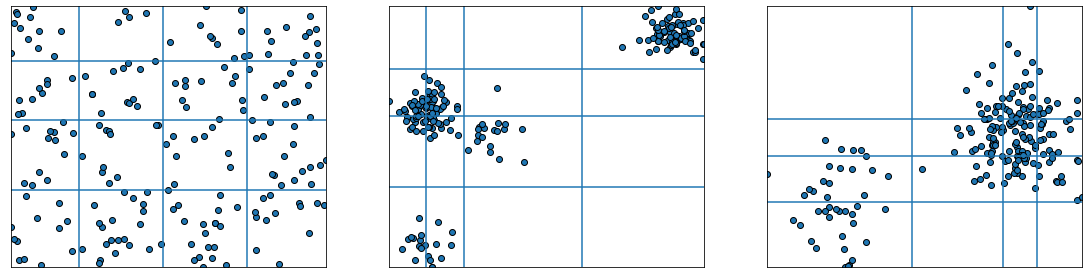

In [10]:
bin_edges = [disc_k_means(X, 4)[1][:,1:-1] for X in X_list]

figure = plt.figure(figsize=(6.4*3, 4.8))
for idx, X in enumerate(X_list):
    ax = plt.subplot(1, len(X_list), idx+1)
    ax.scatter(X[:, 0], X[:, 1], edgecolors='k')
    
    ax.set_xlim(np.min(X[:,0]), np.max(X[:,0]))
    ax.set_ylim(np.min(X[:,1]), np.max(X[:,1]))
    
    for x in bin_edges[idx][0]:
        ax.axvline(x)
    for y in bin_edges[idx][1]:
        ax.axhline(y)
    
    ax.set_xticks(())
    ax.set_yticks(())

## Kernel density estimation (4 pts)

In [15]:
from sklearn.neighbors import KernelDensity
from sklearn.model_selection import KFold
from sklearn.model_selection import GridSearchCV
from sklearn.model_selection import cross_val_score

def disc_kde_1D(x, plot=False):
    """ Implmentes KDE discretization.
    
    INPUT:
        x: one dimensional numpy array with the features to discretize
               
    OUTPUT:
        b: the bin edges
    """
    
    n = len(x)
    x = np.array(x)
    x.sort()
    
    # Select an appropiate bw candidates
    xmin = x[0]
    xmax = x[-1]
    xrange = xmax - xmin
    bw_l = np.linspace(0.01*xrange, xrange, 100)
    bw_scores = np.zeros(len(bw_l))
   
    # Use 10-fold CV. Find the corresponding train and test for each fold.
    # Note: Since x is ordered, maybe systematic sampling would give better cv results.
    folds = list(KFold(n_splits=10, shuffle=True, random_state=11).split(x))

    best_params = GridSearchCV(KernelDensity(kernel='gaussian'), {'bandwidth': bw_l}, cv=folds).fit(x.reshape(-1, 1)).best_params_

    # Iterating over each fold by hand (same result as above)
    """for i, bw in enumerate(bw_l):
        
        scores = []
        for train_index, test_index in folds:
            kernel = KernelDensity(bandwidth=bw, kernel='gaussian').fit(x[train_index].reshape(-1,1))
            scores.append(kernel.score(x[test_index].reshape(-1,1)))

        bw_scores[i] = np.mean(scores)"""

    # It seems the best bw benefits from some smoothing, need to explore this more, systematic sampling may solve this.
    #best_bw = 1.5*bw_l[np.argmax(bw_scores)]
    best_bw = 1.5*best_params['bandwidth']
    

    # List to store bin edges
    bin_edges = [xmin]
    
    # Find local minima using a grid, other option is to use data poitns.
    grid_x = np.linspace(xmin, xmax, 100)
    kde_full = KernelDensity(bandwidth=best_bw, kernel='gaussian').fit(x.reshape(-1,1)).score_samples(grid_x.reshape(-1,1))

    """if  (kde_full[0] <  kde_full[1]):
        bin_edges.append(grid_x[0])"""

    for i in range(1, len(kde_full)-1):

        if  (kde_full[i-1] >  kde_full[i]) and (kde_full[i] < kde_full[i+1]):
            bin_edges.append(grid_x[i])

    """if (kde_full[-1] <  kde_full[-2]):
        bin_edges.append(grid_x[-1])"""
        
    bin_edges.append(xmax)
    
    return np.array(bin_edges)  

In [16]:
def disc_kde(X):
    m, n = X.shape
    X_disc = np.zeros(X.shape)
    clims = []
    
    for i in range(n):
        bin_edges = disc_kde_1D(X[:,i])
        bin_edges[0] = -np.inf
        bin_edges[-1] = np.inf
        clims.append(bin_edges)
        X_disc[:,i] = np.searchsorted(bin_edges, X[:,i], side='right') - 1
    
    # Now clims cannot be an array, since there is no guarante
    # that all features will have the same number of bins    
    return X_disc, clims

To test the function employ the following test matrix:

In [17]:
X_test = np.array([[-2, 1, -4,   -1],
                   [-1, 2, -3, -0.5],
                   [ 0, 3, -2,  0.5],
                   [ 1, 4, -1,    2],
                   [-2.1, 1.1, -4.1,   -1.1],
                   [-1.1, 2.1, -3.1, -0.6],
                   [ 0.1, 3.1, -2.1,  0.6],
                   [ 1.1, 4.1, -1.1,    2.1],
                   [-2.2, 1.2, -4.2,   -1.2],
                   [-1.2, 2.2, -3.2, -0.7],
                   [ 0.2, 3.2, -2.2,  0.7],
                   [ 1.2, 4.2, -1.2,    2.2]])

X_disc, bin_edges = disc_kde(X_test)

print("The discretized matrix is:")
print(X_disc)
print("Expected answer:")
print("""[[0. 0. 0. 0.]
 [1. 1. 1. 1.]
 [1. 1. 1. 2.]
 [2. 2. 2. 3.]
 [0. 0. 0. 0.]
 [1. 1. 1. 1.]
 [1. 1. 1. 2.]
 [2. 2. 2. 3.]
 [0. 0. 0. 0.]
 [1. 1. 1. 1.]
 [1. 1. 1. 2.]
 [2. 2. 2. 3.]]""")
print()

print("The bin edges are:")
for b in bin_edges:
    print(b)
print("Expected edges:")
print("""[       -inf -1.61616162  0.61616162         inf]
[      -inf 1.61414141 3.58585859        inf]
[       -inf -3.58585859 -1.61414141         inf]
[       -inf -0.85656566  0.0020202   1.34141414         inf]
""")


The discretized matrix is:
[[0. 0. 0. 0.]
 [1. 1. 1. 1.]
 [1. 1. 1. 2.]
 [2. 2. 2. 3.]
 [0. 0. 0. 0.]
 [1. 1. 1. 1.]
 [1. 1. 1. 2.]
 [2. 2. 2. 3.]
 [0. 0. 0. 0.]
 [1. 1. 1. 1.]
 [1. 1. 1. 2.]
 [2. 2. 2. 3.]]
Expected answer:
[[0. 0. 0. 0.]
 [1. 1. 1. 1.]
 [1. 1. 1. 2.]
 [2. 2. 2. 3.]
 [0. 0. 0. 0.]
 [1. 1. 1. 1.]
 [1. 1. 1. 2.]
 [2. 2. 2. 3.]
 [0. 0. 0. 0.]
 [1. 1. 1. 1.]
 [1. 1. 1. 2.]
 [2. 2. 2. 3.]]

The bin edges are:
[       -inf -1.61616162  0.61616162         inf]
[      -inf 1.61414141 3.58585859        inf]
[       -inf -3.58585859 -1.61414141         inf]
[       -inf -0.85656566  0.0020202   1.34141414         inf]
Expected edges:
[       -inf -1.61616162  0.61616162         inf]
[      -inf 1.61414141 3.58585859        inf]
[       -inf -3.58585859 -1.61414141         inf]
[       -inf -0.85656566  0.0020202   1.34141414         inf]



The following code plots the sample data sets with the found partitions:

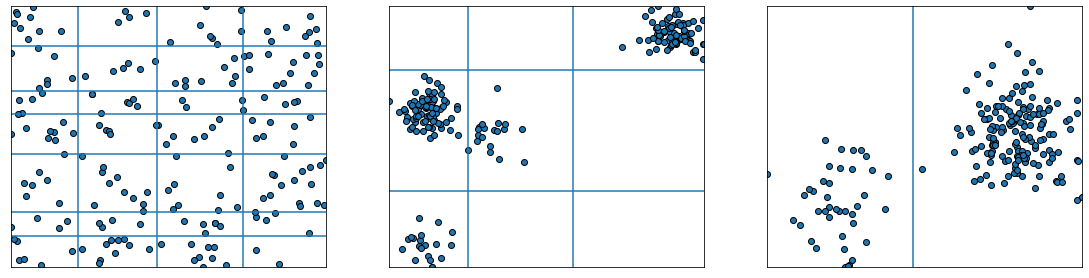

In [20]:
bin_edges = [disc_kde(X)[1] for X in X_list]

figure = plt.figure(figsize=(6.4*3, 4.8))
for idx, X in enumerate(X_list):
    ax = plt.subplot(1, len(X_list), idx+1)
    ax.scatter(X[:, 0], X[:, 1], edgecolors='k')
    
    ax.set_xlim(np.min(X[:,0]), np.max(X[:,0]))
    ax.set_ylim(np.min(X[:,1]), np.max(X[:,1]))
    
    for x in bin_edges[idx][0][1:-1]:
        ax.axvline(x)
    for y in bin_edges[idx][1][1:-1]:
        ax.axhline(y)
    
    ax.set_xticks(())
    ax.set_yticks(())